# Jun 22nd, 2022 (Debug degree + anomalous run 9-2-1 detected)

**Motivation**: Read conclusions at the end for degree debug.  For anomalous run: i should remove those 1-2 infinitely large timepoints before applying bandpassing. <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(128)

mode = 'ca2'
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

In [3]:
adj_all = []
for key in mice.ca:
    net = Network(mice=mice, key=key, mode=mode).load_network()
    adj_all.append(np.expand_dims(net.adj, 0))
adj_all = np.concatenate(adj_all)
adj_all.shape

(110, 152, 152)

---
---

## Start showcasing outlier run

In [4]:
key = mice.get_key(9, 2, 1)
net = Network(mice=mice, key=key, mode=mode, prep_data=True).load_network()

i = list(mice.ca).index(key)
i

90

<matplotlib.colorbar.Colorbar object at 0x7f6d3b5c4a90>

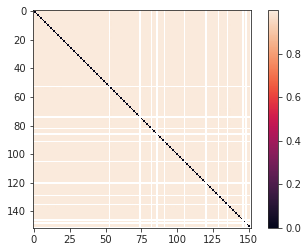

In [5]:
plt.imshow(adj_all[i])
plt.colorbar()

<AxesSubplot:ylabel='Count'>

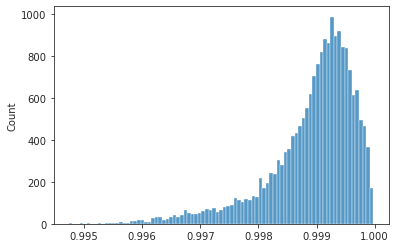

In [6]:
sns.histplot(adj_all[i][adj_all[i] > 0])

<AxesSubplot:ylabel='Count'>

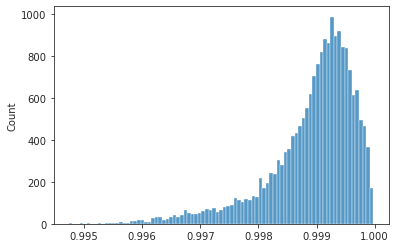

In [7]:
sns.histplot(net.adj[net.adj > 0])

In [8]:
net.data.shape

(152, 4190)

[<matplotlib.lines.Line2D object at 0x7f6d00467c70>]

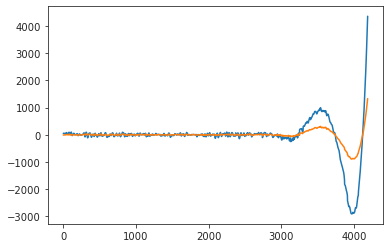

In [9]:
plt.plot(net.data[13])
plt.plot(net.data[79])

[<matplotlib.lines.Line2D object at 0x7f6d003c96a0>]

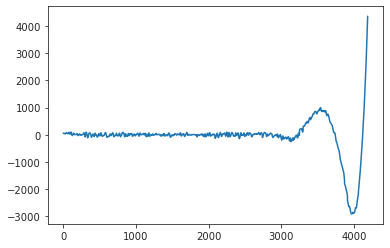

In [10]:
plt.plot(mice.ca[key][13])

In [11]:
mice.setup_preproc_data()

In [12]:
y = mice.ca_preproc[key].load_ants().numpy().squeeze()
y.shape

(256, 250, 5999)

[<matplotlib.lines.Line2D object at 0x7f6ca4a80310>]

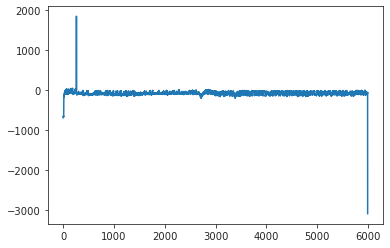

In [13]:
plt.plot(y.mean(0).mean(0))

In [14]:
key

'sub-SLC09_ses-2_run-1'

## End showcasing outlier run

---
---

## Start exploring degree

Should I fill isolated (disconnected) nodes with nan?  Probably not

In [15]:
key = mice.get_key(5, 1, 1)
net = Network(mice=mice, key=key, mode=mode, prep_data=True).load_network()

i = list(mice.ca).index(key)
i

42

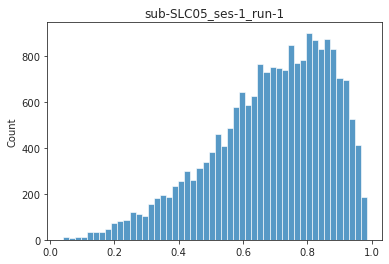

In [16]:
sns.histplot(adj_all[i][adj_all[i] > 0])
plt.title(list(mice.ca)[i]);

In [17]:
self = net
self.data.shape

(152, 4670)

In [18]:
bad_time = np.isnan(self.data).sum(0) == len(self.data)
bad_time.sum()

0

In [19]:
good_nodes = np.isnan(self.data).sum(1) == bad_time.sum()
good_nodes.sum()

143

In [20]:
m = good_nodes.reshape(-1, 1) @ good_nodes.reshape(1, -1)
x = self.data[good_nodes][:, ~bad_time]

In [21]:
a = np_nans((len(self.data),) * 2)
p = np_nans((len(self.data),) * 2)

In [22]:
_a, _p = get_adj_mat(x, self.metric)
a[m], p[m] = _a.flat, _p.flat

_a.shape, a.shape

((143, 143), (152, 152))

<matplotlib.colorbar.Colorbar object at 0x7f6d00438310>

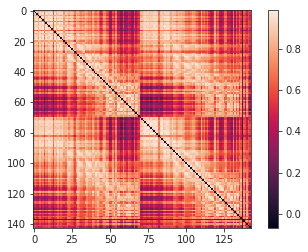

In [23]:
plt.imshow(_a)
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f6d57f6b460>

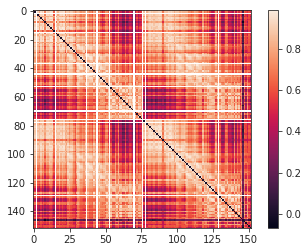

In [24]:
plt.imshow(a)
plt.colorbar()

In [25]:
self.adj, self.p_val = a, p

In [26]:
rho = [p / 100 for p in self.percentiles]
rho

[0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

In [27]:
thresholds = calculate_threshold(self.adj, rho, verbose=True)
thresholds = np.maximum(thresholds, 0.0)
self.thresholds = dict(zip(self.percentiles, thresholds))

threshold = 0.789   /   density:  requested = 0.35000, result = 0.35004;

threshold = 0.811   /   density:  requested = 0.30000, result = 0.30001;

threshold = 0.833   /   density:  requested = 0.25000, result = 0.24998;

threshold = 0.856   /   density:  requested = 0.20000, result = 0.20004;

threshold = 0.878   /   density:  requested = 0.15000, result = 0.15000;

threshold = 0.903   /   density:  requested = 0.10000, result = 0.10007;

threshold = 0.931   /   density:  requested = 0.05000, result = 0.05003;

In [28]:
self.thresholds

{
    35: 0.7891313344390222,
    30: 0.8108873987437235,
    25: 0.8330686018909949,
    20: 0.8560387171717714,
    15: 0.8778588208485606,
    10: 0.9034859526328265,
    5: 0.9314638289590776
}

In [29]:
self.thresholds[20]

0.8560387171717714

In [30]:
for p, th in zip(self.percentiles, thresholds):
    a = self.adj.copy()
    a[a <= th] = 0.
    if self.binarize:
        a[a > th] = 1.
    zero = np.nanmean(a, 0) == 0
    self.disconnected[p] = np.where(zero)[0]
    nonzero = np.nanmean(a, 0) > 0
    m = nonzero.reshape(-1, 1) @ nonzero.reshape(1, -1)
    a[~m] = np.nan
    self.adjacencies[p] = a

In [31]:
self.disconnected

{
    35: array([ 90, 144, 146, 148, 150, 151]),
    30: array([ 90, 144, 146, 148, 150, 151]),
    25: array([ 90, 144, 146, 148, 150, 151]),
    20: array([ 14,  90, 144, 146, 147, 148, 149, 150, 151]),
    15: array([  0,  14,  75,  90, 142, 144, 146, 147, 148, 149, 150, 151]),
    10: array([  0,   4,   8,  14,  22,  75,  90,  98, 142, 144, 145, 146, 147,
       148, 149, 150, 151]),
    5: array([  0,   4,   8,  14,  17,  22,  29,  30,  35,  43,  49,  50,  59,
        75,  77,  79,  90,  98, 134, 142, 144, 145, 146, 147, 148, 149,
       150, 151])
}

<matplotlib.image.AxesImage object at 0x7f6ca48f0dc0>

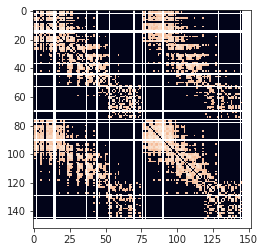

In [32]:
plt.imshow(self.adjacencies[20])

In [33]:
len(self.n2l), good_nodes.sum()

(152, 143)

In [34]:
np.where(~good_nodes)[0]

array([  2,  15,  37,  44,  53,  70,  76,  78, 129])

In [35]:
th = self.thresholds[20]
a = self.adj.copy()
a[a <= th] = 0.

<matplotlib.image.AxesImage object at 0x7f6ca4826df0>

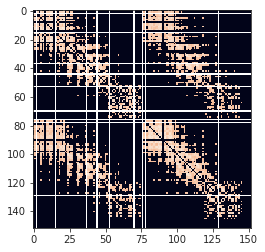

In [36]:
plt.imshow(a)

In [37]:
np.nanmean(a, 0)

array([0.05459886, 0.25358699,        nan, 0.21653845, 0.06687893,
       0.3444198 , 0.18976531, 0.27069962, 0.00615619, 0.26419736,
       0.2168357 , 0.34307214, 0.30877225, 0.2594733 , 0.        ,
              nan, 0.25645574, 0.18517703, 0.38302822, 0.27506761,
       0.2696399 , 0.32351474, 0.03059746, 0.14979025, 0.39373618,
       0.27271094, 0.33030386, 0.27173521, 0.07541199, 0.01257924,
       0.12299114, 0.36272319, 0.27577917, 0.15263076, 0.22102718,
       0.06863078, 0.2514452 ,        nan, 0.32552314, 0.19726197,
       0.22322386, 0.15692483, 0.25158421, 0.11793851,        nan,
       0.24153378, 0.23973917, 0.17837157, 0.09394916, 0.14966995,
       0.24296271, 0.13351217, 0.27030977,        nan, 0.15459047,
       0.0943341 , 0.10033355, 0.12982332, 0.10861284, 0.09894434,
       0.1595979 , 0.15415412, 0.05721253, 0.08949058, 0.09319649,
       0.1069291 , 0.07678333, 0.20870108, 0.13353131, 0.0936296 ,
              nan, 0.08194446, 0.031009  , 0.08201819, 0.09302364,
       0.00599693,        nan, 0.1794811 ,        nan, 0.11713914,
       0.25217421, 0.28896094, 0.2165892 , 0.23833034, 0.23775689,
       0.2180942 , 0.23559297, 0.34428852, 0.32253537, 0.25718857,
       0.        , 0.22250493, 0.23861307, 0.30103329, 0.39838678,
       0.28487121, 0.38677646, 0.34192951, 0.09766489, 0.27857434,
       0.37483878, 0.37751314, 0.22978114, 0.34063284, 0.28101717,
       0.19908724, 0.17504329, 0.3319122 , 0.19158256, 0.22944632,
       0.20191241, 0.23004868, 0.25236388, 0.19999112, 0.28654113,
       0.21622735, 0.19647254, 0.15723022, 0.21453315, 0.21802704,
       0.16756864, 0.19509747, 0.17655559, 0.21344897, 0.15100391,
       0.137414  , 0.0887437 , 0.13181925, 0.16185077,        nan,
       0.12696689, 0.1902833 , 0.12580541, 0.1124731 , 0.04941198,
       0.04995983, 0.14137772, 0.09754283, 0.14393121, 0.11290264,
       0.04346342, 0.15209752, 0.01210722, 0.10251805, 0.        ,
       0.04906355, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [38]:
nonzero = np.nanmean(a, 0) > 0

<matplotlib.image.AxesImage object at 0x7f6ca48b5730>

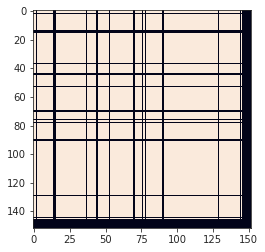

In [39]:
m = nonzero.reshape(-1, 1) @ nonzero.reshape(1, -1)
plt.imshow(m)

In [42]:
len(self.n2l) - (m.sum(0) == 0).sum()

134

In [43]:
key

'sub-SLC05_ses-1_run-1'

In [44]:
(~np.isnan(np.nanmean(self.adjacencies[20], 0))).sum()

134

WE observe that n134 shows up in svinet: n134-k20-mmsb-seed153-linksampling etc, therefore it makes sense.

### Q: d = 20 or not? at n = 134

In [55]:
a_test = self.adjacencies[20].copy()
effective = np.nansum(a_test, 0) > 0
a_test = a_test[effective][:, effective]
a_test.shape

(134, 134)

<matplotlib.image.AxesImage object at 0x7f6ca4773fd0>

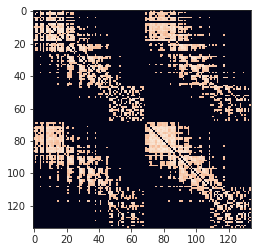

In [56]:
plt.imshow(a_test)

In [62]:
g = nx.from_numpy_array(a_test.astype(bool).astype(float))

<matplotlib.image.AxesImage object at 0x7f6c51640c10>

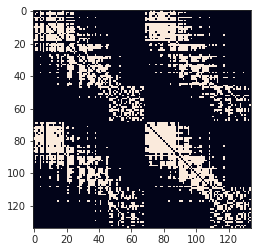

In [64]:
a_from_g = nx.adjacency_matrix(g).toarray()
plt.imshow(a_from_g)

In [66]:
nx.density(g)

0.2279205476377511

In [75]:
def collect_degrees_lite(
		mice: Mice,
		mode: str,
		rho: float = 0.2,
		filter_isolated: bool = False,
		**kwargs, ):
	task = kwargs.get('task')
	if task is None:
		task = 'rest'
		kwargs['task'] = task
	proc, *_ = mice.get_data_containers(
		mode=mode, force=True, **kwargs)
	degrees = {}
	for key, f in proc.items():
		if mice.looper[key][-1] == -1:
			continue
		net = Network(
			mice=mice,
			key=key,
			mode=mode,
			task=f.task,
		).load_network(full=False)
		if not net:
			continue
		good = np.isfinite(net.adj).sum(0) > 0
		threshold = calculate_threshold(net.adj, rho).item()
		a = net.adj.copy()
		a[net.adj <= threshold] = 0
		a[net.adj > threshold] = 1
		deg = bn.nansum(a, -1)
		deg[~good] = np.nan
		if filter_isolated:
			deg[deg == 0] = np.nan
		degrees[key] = deg
	return degrees

In [76]:
kws = {'band_ca': (0.01, 0.5), 'task': 'rest'}
degrees = collect_degrees_lite(mice, 'ca2', filter_isolated=False, **kws)

In [77]:
len(degrees)

110

In [78]:
len(degrees[key]), (degrees[key] > 0).sum()

(152, 134)

In [82]:
np.where(degrees[key] == 0)[0], self.disconnected[20]

(
    array([ 14,  90, 144, 146, 147, 148, 149, 150, 151]),
    array([ 14,  90, 144, 146, 147, 148, 149, 150, 151])
)

In [87]:
xxx = self.adjacencies[20].copy()
xxx[xxx > 0] = 1
np.nansum(xxx, 0)

array([ 9., 40.,  0., 34., 11., 54., 30., 42.,  1., 41., 34., 54., 48.,
       40.,  0.,  0., 40., 30., 60., 43., 42., 50.,  5., 24., 62., 43.,
       52., 43., 12.,  2., 20., 57., 43., 24., 35., 11., 40.,  0., 51.,
       31., 35., 25., 40., 19.,  0., 38., 38., 28., 15., 24., 39., 21.,
       43.,  0., 24., 15., 16., 21., 17., 16., 25., 24.,  9., 14., 15.,
       17., 12., 33., 21., 15.,  0., 13.,  5., 13., 15.,  1.,  0., 29.,
        0., 19., 40., 45., 34., 37., 38., 34., 37., 54., 50., 40.,  0.,
       35., 37., 48., 62., 44., 60., 54., 16., 44., 59., 59., 36., 54.,
       45., 32., 28., 52., 30., 36., 32., 37., 40., 32., 45., 34., 31.,
       25., 34., 35., 27., 31., 28., 34., 24., 22., 14., 21., 25.,  0.,
       20., 30., 20., 18.,  8.,  8., 22., 15., 23., 18.,  7., 24.,  2.,
       16.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.])

In [86]:
degrees[key]

array([ 9., 40., nan, 34., 11., 54., 30., 42.,  1., 41., 34., 54., 48.,
       40.,  0., nan, 40., 30., 60., 43., 42., 50.,  5., 24., 62., 43.,
       52., 43., 12.,  2., 20., 57., 43., 24., 35., 11., 40., nan, 51.,
       31., 35., 25., 40., 19., nan, 38., 38., 28., 15., 24., 39., 21.,
       43., nan, 24., 15., 16., 21., 17., 16., 25., 24.,  9., 14., 15.,
       17., 12., 33., 21., 15., nan, 13.,  5., 13., 15.,  1., nan, 29.,
       nan, 19., 40., 45., 34., 37., 38., 34., 37., 54., 50., 40.,  0.,
       35., 37., 48., 62., 44., 60., 54., 16., 44., 59., 59., 36., 54.,
       45., 32., 28., 52., 30., 36., 32., 37., 40., 32., 45., 34., 31.,
       25., 34., 35., 27., 31., 28., 34., 24., 22., 14., 21., 25., nan,
       20., 30., 20., 18.,  8.,  8., 22., 15., 23., 18.,  7., 24.,  2.,
       16.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.])

In [88]:
np.isfinite(degrees[key]).sum()

143

In [90]:
np.array_equal(np.isfinite(degrees[key]), np.isfinite(net.adj).sum(0) > 0)

True

In [91]:
np.array_equal(good_nodes, np.isfinite(net.adj).sum(0) > 0)

True

[<matplotlib.lines.Line2D object at 0x7f6ca487b9a0>]

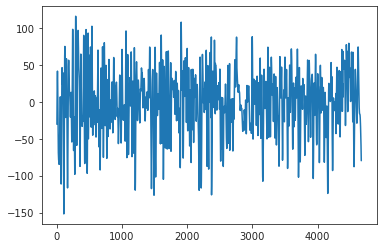

In [45]:
plt.plot(bn.nanmean(self.data, 0))

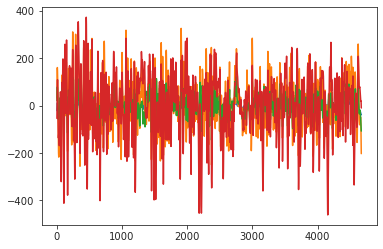

In [46]:
plt.plot(self.data[[30, 40, 50, 60, 70]].T);

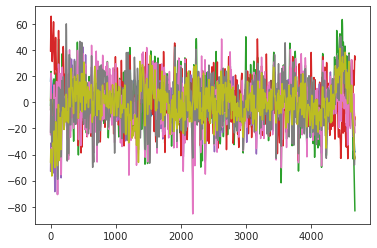

In [47]:
plt.plot(self.data[self.disconnected[20]].T);

In [48]:
self.mice.band

{'bold': (0.01, 0.5), 'ca2': (0.01, 0.5)}

## Conclusions:

- Right now, collect_degrees_lite() works as intended.  It collects degrees, where we have:
    - Nonzero elements: the majority of nodes have nonzero connectivity
    - Nans: these were the nodes missing from the beginning (even in self.data)
    - Zeros: there are nodes that don't have correlation values higher than a given threshold, they are zeroed-out in the process of binarization which is fine.
    
More on the disconnected nodes:
- This happens.  They should remain in the output of collect degree functions because removing them (by filling in with nans) changes the density of the graph.
- For instance in the above example, the graph density is 0.20 with the disconnected nodes included, however, after nanning them out, we get a density of 0.23 or something like that which is not desirable.

In [96]:
kws = {'band_ca': (0.01, 0.5), 'task': 'rest'}

degrees = collect_degrees_lite(mice, 'ca2', filter_isolated=False, **kws)
degrees = [np.expand_dims(v, 0) for v in degrees.values()]
degrees = np.concatenate(degrees)

degrees_filt = collect_degrees_lite(mice, 'ca2', filter_isolated=True, **kws)
degrees_filt = [np.expand_dims(v, 0) for v in degrees_filt.values()]
degrees_filt = np.concatenate(degrees_filt)

degrees.shape, degrees_filt.shape

((110, 152), (110, 152))

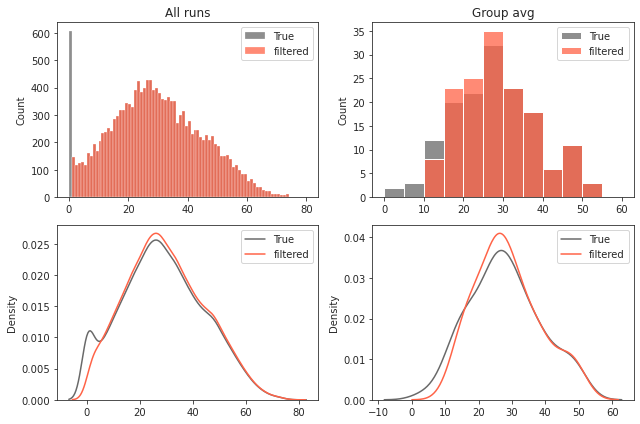

In [121]:
fig, axes = create_figure(2, 2, (9, 6))

bins = np.linspace(0, 80, 81)
sns.histplot(degrees.ravel(), color='dimgrey', label='True', bins=bins, ax=axes[0, 0])
sns.histplot(degrees_filt.ravel(), color='tomato', label='filtered', bins=bins, ax=axes[0, 0])

bins = np.linspace(0, 60, 13)
sns.histplot(bn.nanmean(degrees, 0), color='dimgrey', label='True', bins=bins, ax=axes[0, 1])
sns.histplot(bn.nanmean(degrees_filt, 0), color='tomato', label='filtered', bins=bins, ax=axes[0, 1])

sns.kdeplot(degrees.ravel(), color='dimgrey', label='True', ax=axes[1, 0])
sns.kdeplot(degrees_filt.ravel(), color='tomato', label='filtered', ax=axes[1, 0])

sns.kdeplot(bn.nanmean(degrees, 0), color='dimgrey', label='True', ax=axes[1, 1])
sns.kdeplot(bn.nanmean(degrees_filt, 0), color='tomato', label='filtered', ax=axes[1, 1])

axes[0, 0].set_title('All runs')
axes[0, 1].set_title('Group avg')
for ax in axes.flat:
    ax.legend()
plt.show()

In [123]:
min(bn.nanmean(degrees, 0)), max(bn.nanmean(degrees, 0))

(3.4791666666666665, 51.10909090909091)

In [124]:
min(bn.nanmean(degrees_filt, 0)), max(bn.nanmean(degrees_filt, 0))

(10.733333333333333, 51.10909090909091)